Encoding and Dataset:

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [31]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Encode the target variable
label_encoder = LabelEncoder()
train_df['nforest_type_encoded'] = label_encoder.fit_transform(train_df['nforest_type'])

# Define features and target
X = train_df.drop(columns=['id', 'nforest_type', 'nforest_type_encoded'])
y = train_df['nforest_type_encoded']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optionally, use PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_scaled)

# Split the transformed data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Convert Series to numpy array first
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)  # Convert Series to numpy array first

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Define and Train the Neural Network:

In [38]:
class ForestNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ForestNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Initialize the neural network, loss function and optimizer
input_dim = X_train.shape[1]
hidden_dim = 256  # Increase the number of neurons
output_dim = len(label_encoder.classes_)
model = ForestNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50)

# Early stopping parameters
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

# Train the neural network
num_epochs = 16
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Accuracy: {100 * correct / total:.2f}%')

    # # Early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1

    # if epochs_no_improve == early_stopping_patience:
    #     print(f'Early stopping at epoch {epoch+1}')
    #     break

Epoch 1/16, Train Loss: 0.8884, Val Loss: 0.8000, Val Accuracy: 65.26%
Epoch 2/16, Train Loss: 0.7969, Val Loss: 0.7490, Val Accuracy: 66.10%
Epoch 3/16, Train Loss: 0.7639, Val Loss: 0.7431, Val Accuracy: 67.18%
Epoch 4/16, Train Loss: 0.7497, Val Loss: 0.7203, Val Accuracy: 68.67%
Epoch 5/16, Train Loss: 0.7373, Val Loss: 0.7129, Val Accuracy: 69.67%
Epoch 6/16, Train Loss: 0.7302, Val Loss: 0.7011, Val Accuracy: 69.71%
Epoch 7/16, Train Loss: 0.7219, Val Loss: 0.7175, Val Accuracy: 68.02%
Epoch 8/16, Train Loss: 0.7166, Val Loss: 0.6983, Val Accuracy: 69.78%
Epoch 9/16, Train Loss: 0.7080, Val Loss: 0.7025, Val Accuracy: 68.44%
Epoch 10/16, Train Loss: 0.7017, Val Loss: 0.6918, Val Accuracy: 70.20%
Epoch 11/16, Train Loss: 0.6962, Val Loss: 0.6864, Val Accuracy: 70.36%
Epoch 12/16, Train Loss: 0.6919, Val Loss: 0.6933, Val Accuracy: 69.48%
Epoch 13/16, Train Loss: 0.6866, Val Loss: 0.6799, Val Accuracy: 71.08%
Epoch 14/16, Train Loss: 0.6816, Val Loss: 0.6926, Val Accuracy: 70.05%
E

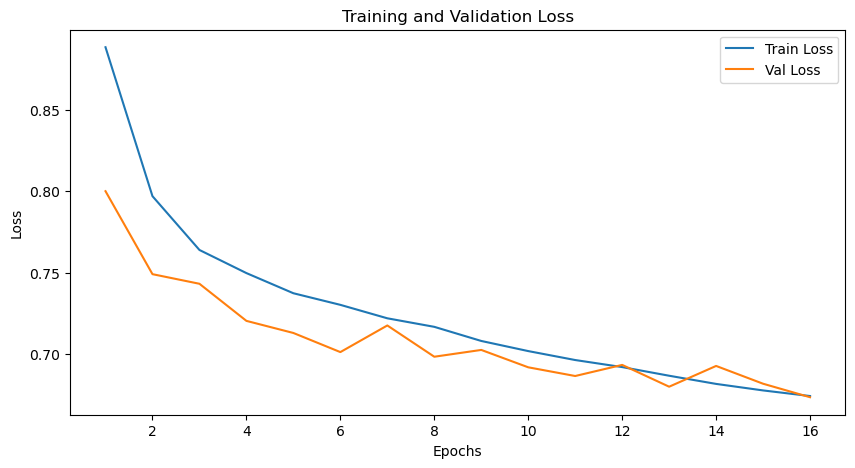

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Make Prediction:

In [40]:
# Prepare the test data
test_X = test_df.drop(columns=['id'])
test_X_scaled = scaler.transform(test_X)
test_X_pca = pca.transform(test_X_scaled)
test_X_tensor = torch.tensor(test_X_pca, dtype=torch.float32)

# Make predictions
model.eval()
with torch.no_grad():
    test_outputs = model(test_X_tensor)
    _, test_predictions = torch.max(test_outputs.data, 1)

test_predictions_decoded = label_encoder.inverse_transform(test_predictions.numpy())


Inference:

In [41]:
# Load your sample submission file
sample_submission = pd.read_csv('sample_submission.csv')

# Merge the test data with sample submission to fill in the predicted values
predictions_df = pd.DataFrame({'id': test_df['id'], 'nforest_type': test_predictions_decoded})
final_submission = sample_submission.merge(predictions_df, on='id', how='left', suffixes=('', '_predicted'))

# Fill the missing values in sample submission with the predicted values
final_submission['nforest_type'] = final_submission['nforest_type'].combine_first(final_submission['nforest_type_predicted'])

# Drop the predicted column as it's no longer needed
final_submission = final_submission.drop(columns=['nforest_type_predicted'])

# Save the final submission
final_submission.to_csv('submitfile/NNAdamW.csv', index=False)